# Latin Hypercube Sampling (LHS) Demonstration

This notebook illustrates the working principles of Latin Hypercube Sampling (LHS). We will start with a simple 2-dimensional case and increase the number of dimensions up to 5, while keeping the number of sample points $k$ fixed at 2.

## What is Latin Hypercube Sampling?

Latin Hypercube Sampling is a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. The key feature of LHS is **stratification**: it ensures that the sample is stratified across all possible values of each input variable.

In a $n$-dimensional space with $k$ sample points:
1. The range of each dimension is divided into $k$ equal intervals.
2. A sample point is placed such that there is exactly one point in each interval for every dimension.

This is analogous to the "Latin Square" concept where there is only one item in each row and column.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

## A Basic Latin Hypercube Sampler

Before using the built-in library functions, let's understand how Latin Hypercube Sampling works by implementing a basic sampler from scratch.

In [2]:
def lh_sampler(n, k, seed=None, shuffle=True):
    """
    Generate Latin Hypercube samples from scratch.
    
    This function illustrates the basic algorithm for generating LHS:
    1. Divide each dimension into k equally-sized intervals
    2. For each dimension, randomly select one point from each interval
    3. Randomly permute the order of selections across dimensions
    
    Parameters:
    -----------
    n : int
        Number of dimensions
    k : int
        Number of sample points        
    seed : int, optional
        Random seed for reproducibility
    shuffle:
        Whether to use shuffeling
    
    Returns:
    --------
    samples : numpy.ndarray
        Latin Hypercube samples of shape (k, n), values in [0, 1]
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize the sample array
    samples = np.zeros((k, n))
    
    # For each dimension
    for dim in range(n):
        # Step 1: Divide the range [0, 1] into k intervals
        # Each interval is [i/k, (i+1)/k] for i = 0, 1, ..., k-1
        
        # Step 2: For each interval, randomly select one point
        for i in range(k):
            # Select a random point within the i-th interval
            lower_bound = i / k
            upper_bound = (i + 1) / k
            samples[i, dim] = np.random.uniform(lower_bound, upper_bound)
            print(f"Added {i+1}th sample {samples[i, dim]} to dimension {dim + 1}")
        
        if shuffle:
            print(f"Samples before shuffeling:\n{samples}")
            # Step 3: Randomly permute the samples in this dimension
            # This ensures that each interval is used exactly once and the samples are not distributed
            # along the main diagonal
            np.random.shuffle(samples[:, dim])
            print(f"Samples after shuffeling:\n{samples}")
    
    return samples


### Example: Generate a 2D Latin Hypercube with 5 points

Example: n=2 dimensions, k=5 sample points
Added 1th sample 0.0749080237694725 to dimension 1
Added 2th sample 0.3901428612819833 to dimension 1
Added 3th sample 0.5463987883622811 to dimension 1
Added 4th sample 0.7197316968394073 to dimension 1
Added 5th sample 0.8312037280884873 to dimension 1
Samples before shuffeling:
[[0.07490802 0.        ]
 [0.39014286 0.        ]
 [0.54639879 0.        ]
 [0.7197317  0.        ]
 [0.83120373 0.        ]]
Samples after shuffeling:
[[0.39014286 0.        ]
 [0.07490802 0.        ]
 [0.7197317  0.        ]
 [0.83120373 0.        ]
 [0.54639879 0.        ]]
Added 1th sample 0.17323522915498704 to dimension 2
Added 2th sample 0.32022300234864176 to dimension 2
Added 3th sample 0.5416145155592091 to dimension 2
Added 4th sample 0.6041168988591604 to dimension 2
Added 5th sample 0.9939819704323989 to dimension 2
Samples before shuffeling:
[[0.39014286 0.17323523]
 [0.07490802 0.320223  ]
 [0.7197317  0.54161452]
 [0.83120373 0.6041169 ]
 [0.54639879 

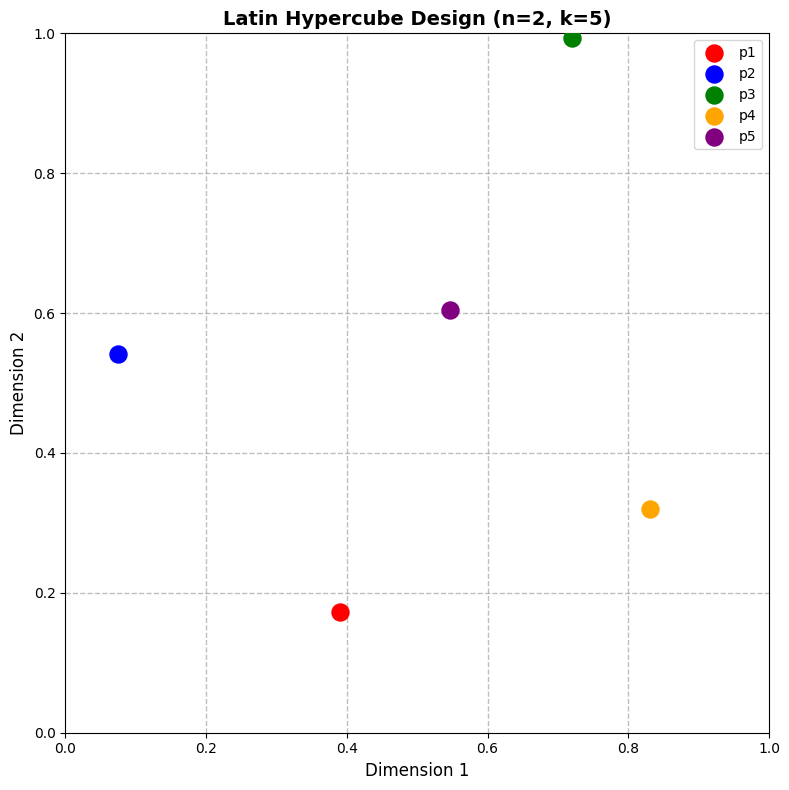

In [3]:
print("Example: n=2 dimensions, k=5 sample points")
print("=" * 50)
sample = lh_sampler(n=2, k=5, seed=42, shuffle=True)
print("\nGenerated LHS samples:")
print(sample)
print("\n" + "=" * 50)
print("Notice:")
print("- Each value is between 0 and 1")
print("- For each dimension (column), values are spread across k=5 intervals")
print("- Each interval [0, 0.2), [0.2, 0.4), [0.4, 0.6), [0.6, 0.8), [0.8, 1.0)")
print("  contains exactly one sample per dimension")

# Plot the 2D design
k = len(sample)
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(8, 8))
for i in range(k):
    plt.scatter(sample[i, 0], sample[i, 1], c=colors[i], s=150, label=f'p{i+1}', zorder=3)

# Draw grid lines showing the k intervals
for i in range(1, k):
    plt.axvline(i/k, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(i/k, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Latin Hypercube Design (n=2, k=5)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()
        

## General Function for LHS Visualization

Now let's create a general function `show_lhd(n, k)` that works for any combination of dimensions and sample points. This function will generate both 3D plots (when applicable), 2D projection plots, and parallel coordinate plots, if applicable.

### Viewing Angles for 3D Plots

For 3D visualizations (when `n=3`), the function allows you to control the viewpoint using two parameters:

- **`elev`** (elevation angle): Controls the vertical viewing angle in degrees
  - `elev = 0°`: View from the horizontal plane (side view)
  - `elev = 45°`: View from 45° above the horizontal
  - `elev = 90°`: View from directly above (top-down view)

- **`azim`** (azimuthal angle): Controls the horizontal rotation angle in degrees
  - `azim = 0°`: View from the front
  - `azim = 45°`: Rotated 45° around the vertical axis
  - `azim = 90°`: View from the side

#### Examples:
- `show_lhd(n=3, k=4, elev=20, azim=45)` - Default oblique view
- `show_lhd(n=3, k=4, elev=0, azim=0)` - Side view from the front
- `show_lhd(n=3, k=4, elev=90, azim=0)` - Top-down view

#### Multiple Viewpoints:
You can also provide **lists** of angles to generate multiple 3D plots with different perspectives:
- `show_lhd(n=3, k=4, elev=[20, 45, 90], azim=[45, 45, 0])` - Creates 3 plots with different views
- Both lists must have the same length, otherwise an error is raised



In [4]:
def show_lhd(n, k, seed=42, elev=20, azim=45):
    """
    Generate and visualize Latin Hypercube Design (LHD) samples.
    
    Parameters:
    -----------
    n : int
        Number of dimensions (must be > 1)
    k : int
        Number of sample points (must be > 1)
    seed : int, optional
        Random seed for reproducibility (default: 42)
    elev : float or list of float, optional
        Elevation angle(s) for 3D plot in degrees (default: 20)
        If list, multiple 3D plots with different viewpoints are generated
    azim : float or list of float, optional
        Azimuthal angle(s) for 3D plot in degrees (default: 45)
        If list, must have same length as elev
    
    Returns:
    --------
    sample : numpy.ndarray
        The generated LHD samples of shape (k, n)
    """
    # Validate inputs
    if n < 2:
        raise ValueError("Number of dimensions n must be > 1")
    if k < 2:
        raise ValueError("Number of sample points k must be > 1")
    
    # Handle elev and azim as lists or single values
    elev_list = elev if isinstance(elev, (list, tuple)) else [elev]
    azim_list = azim if isinstance(azim, (list, tuple)) else [azim]
    
    # Validate that elev and azim lists have the same length
    if len(elev_list) != len(azim_list):
        raise ValueError(f"elev and azim must have the same length. Got elev length: {len(elev_list)}, azim length: {len(azim_list)}")
    
    # Initialize LHS sampler
    sampler = qmc.LatinHypercube(d=n, seed=seed)
    sample = sampler.random(n=k)
    
    # Generate colors dynamically based on k
    color_palette = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = color_palette[:k] if k <= len(color_palette) else plt.cm.tab20(np.linspace(0, 1, k))
    
    # Calculate splits based on k
    splits = [i/k for i in range(1, k)]
    
    print(f"Sample points (n={n}, k={k}):")
    print(sample)
    print()
    
    # Determine layout for projection plots
    if n == 2:
        # For 2D: just one plot
        num_projections = 1
        projection_pairs = [(0, 1)]
    elif n == 3:
        # For 3D: three projections
        num_projections = 3
        projection_pairs = [(0, 1), (1, 2), (0, 2)]
    else:
        # For higher dimensions: show first 6 pairwise projections in a grid
        num_projections = min(6, n * (n - 1) // 2)  # At most 6 projections
        projection_pairs = []
        for i in range(n):
            for j in range(i + 1, n):
                if len(projection_pairs) < num_projections:
                    projection_pairs.append((i, j))
    
    # Calculate grid layout (as square as possible)
    if n >= 3:
        # For 3D case: show 3D plot and projections side by side
        if num_projections <= 3:
            grid_rows = 1
            grid_cols = num_projections
        else:
            grid_cols = int(np.ceil(np.sqrt(num_projections)))
            grid_rows = int(np.ceil(num_projections / grid_cols))
    else:
        # For 2D case: just one plot
        grid_rows = 1
        grid_cols = 1
    
    # ===== 3D Plot (only if n == 3) =====
    if n == 3:
        # Helper function to draw splitting planes
        def draw_plane(ax, axis, value, color='blue', alpha=0.15):
            x = np.linspace(0, 1, 10)
            y = np.linspace(0, 1, 10)
            X, Y = np.meshgrid(x, y)
            
            if axis == 'x':
                ax.plot_surface(np.full_like(X, value), X, Y, alpha=alpha, color=color)
            elif axis == 'y':
                ax.plot_surface(X, np.full_like(X, value), Y, alpha=alpha, color=color)
            elif axis == 'z':
                ax.plot_surface(X, Y, np.full_like(X, value), alpha=alpha, color=color)
        
        # Generate one 3D plot for each (elev, azim) pair
        for view_idx, (elev_angle, azim_angle) in enumerate(zip(elev_list, azim_list)):
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            for i in range(k):
                color = colors[i] if isinstance(colors, list) else colors[i]
                ax.scatter(sample[i, 0], sample[i, 1], sample[i, 2], 
                          c=[color], s=100, label=f'p{i+1}')
            
            plane_colors = ['blue', 'green', 'orange']
            for s in splits:
                draw_plane(ax, 'x', s, color=plane_colors[0], alpha=0.15)
                draw_plane(ax, 'y', s, color=plane_colors[1], alpha=0.15)
                draw_plane(ax, 'z', s, color=plane_colors[2], alpha=0.15)
            
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            ax.set_zlabel('Dimension 3')
            
            # Add viewpoint info to title if multiple views
            if len(elev_list) > 1:
                ax.set_title(f'LHS Design (n={n}, k={k}) - View {view_idx+1}: elev={elev_angle}°, azim={azim_angle}°', 
                           fontsize=14, fontweight='bold')
            else:
                ax.set_title(f'LHS Design (n={n}, k={k}) with Splitting Planes', 
                           fontsize=14, fontweight='bold')
            
            ax.legend(loc='upper right')
            
            # Set the viewing angle
            ax.view_init(elev=elev_angle, azim=azim_angle)
            
            plt.tight_layout()
            plt.show()
    
    # ===== 2D Projection Plots =====
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(6*grid_cols, 6*grid_rows))
    
    # Make axs always iterable
    if num_projections == 1:
        axs = [axs]
    else:
        axs = axs.flatten() if grid_rows * grid_cols > 1 else [axs]
    
    dimension_labels = [f'Dimension {i+1}' for i in range(n)]
    
    for proj_idx, (dim_x, dim_y) in enumerate(projection_pairs):
        for i in range(k):
            color = colors[i] if isinstance(colors, list) else colors[i]
            axs[proj_idx].scatter(sample[i, dim_x], sample[i, dim_y], 
                                 c=[color], s=100, label=f'p{i+1}')
        
        # Add splitting lines
        for s in splits:
            axs[proj_idx].axvline(s, color='gray', linestyle='--', alpha=0.5)
            axs[proj_idx].axhline(s, color='gray', linestyle='--', alpha=0.5)
        
        axs[proj_idx].set_xlim(0, 1)
        axs[proj_idx].set_ylim(0, 1)
        axs[proj_idx].set_xlabel(dimension_labels[dim_x], fontsize=11)
        axs[proj_idx].set_ylabel(dimension_labels[dim_y], fontsize=11)
        axs[proj_idx].set_title(f'{dimension_labels[dim_x]} vs {dimension_labels[dim_y]}', 
                               fontsize=12, fontweight='bold')
        axs[proj_idx].legend(loc='upper right')
        axs[proj_idx].set_aspect('equal')
    
    # Hide unused subplots
    for idx in range(num_projections, len(axs)):
        axs[idx].axis('off')
    
    plt.suptitle(f'LHS Projections (n={n}, k={k})', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    # ===== Parallel Coordinates Plot (for n >= 3) =====
    if n >= 3:
        fig, ax = plt.subplots(figsize=(max(10, n*1.5), 6))
        
        for i in range(k):
            color = colors[i] if isinstance(colors, list) else colors[i]
            ax.plot(range(1, n + 1), sample[i], marker='o', markersize=8, 
                   linewidth=2, color=color, label=f'p{i+1}')
        
        ax.set_xlabel('Dimension', fontsize=12, fontweight='bold')
        ax.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax.set_title(f'Parallel Coordinates Plot (n={n}, k={k})', fontsize=14, fontweight='bold')
        ax.set_xticks(range(1, n + 1))
        ax.set_xticklabels([f'D{i}' for i in range(1, n + 1)])
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right', fontsize=10)
        
        # Add horizontal lines at split positions
        for s in splits:
            ax.axhline(s, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        
        plt.tight_layout()
        plt.show()
    
    return sample

### Example Usage

Let's test the `show_lhd()` function with different configurations:

# Example : 3D with 2 points

Sample points (n=3, k=2):
[[0.11302198 0.28056078 0.57070104]
 [0.65131599 0.95291133 0.01218882]]



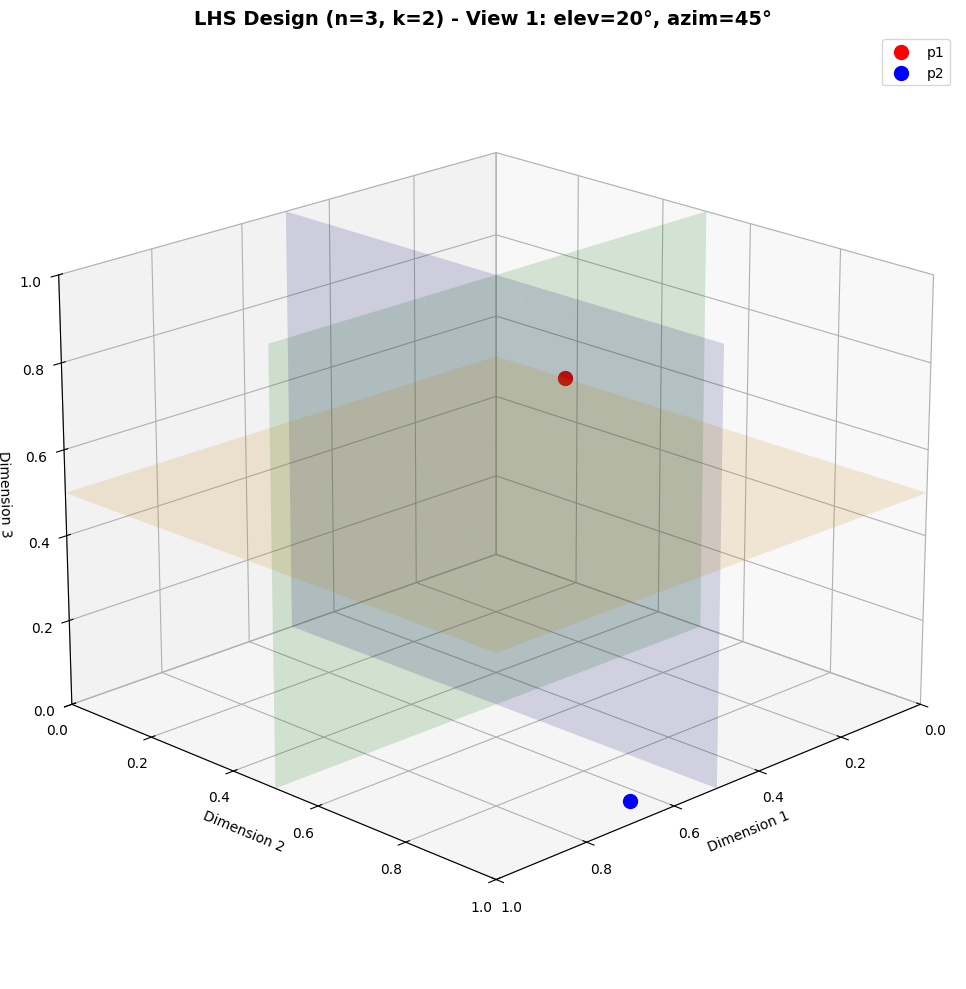

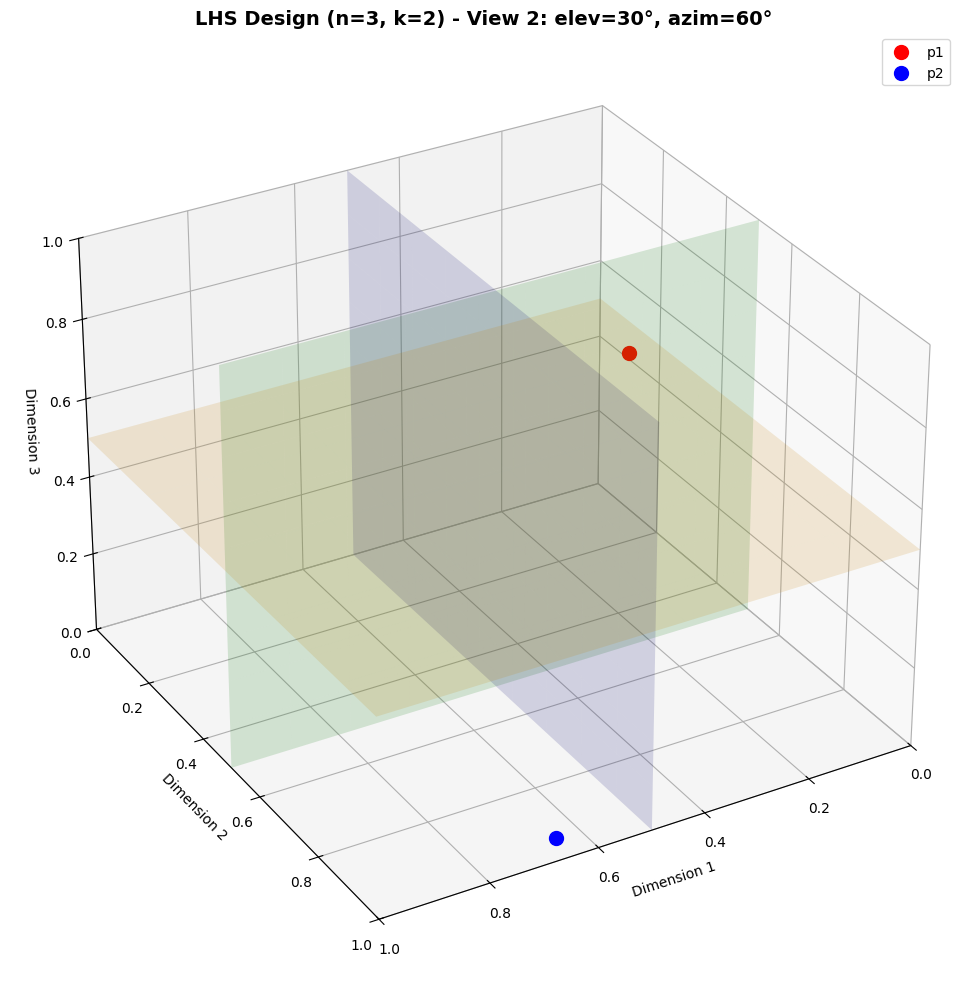

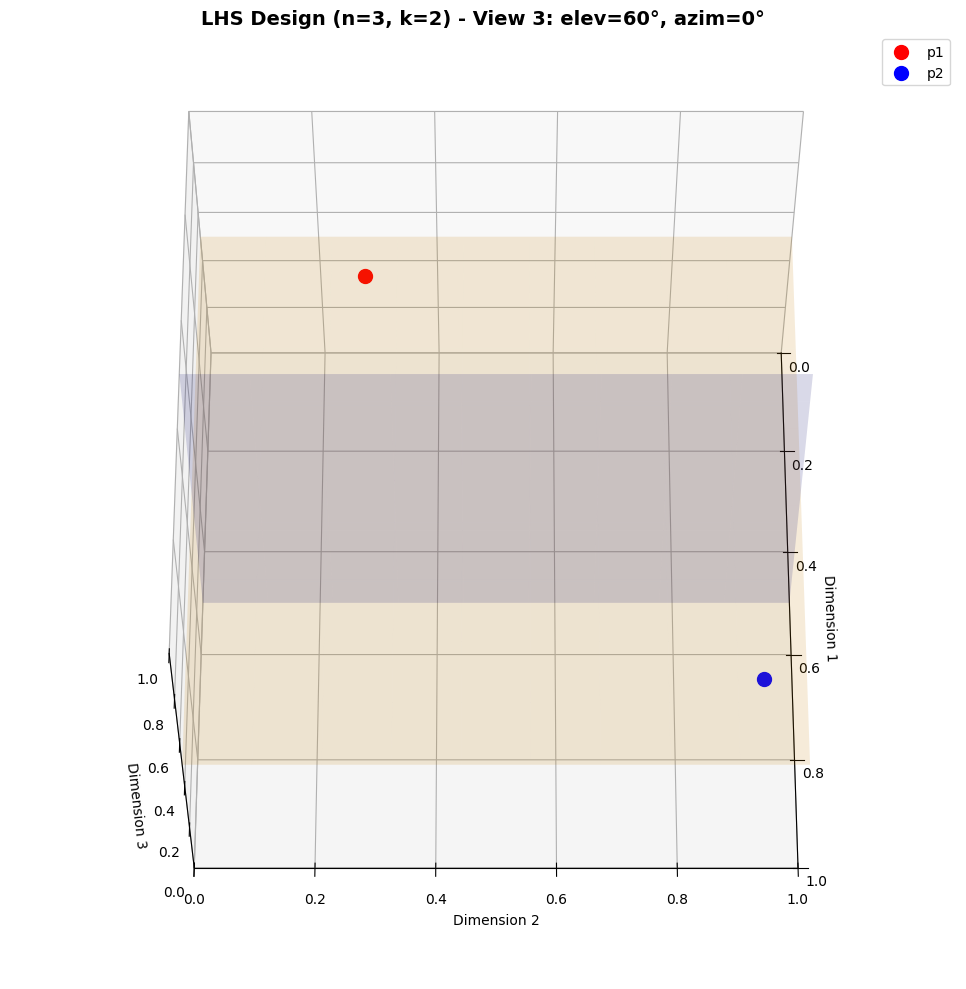

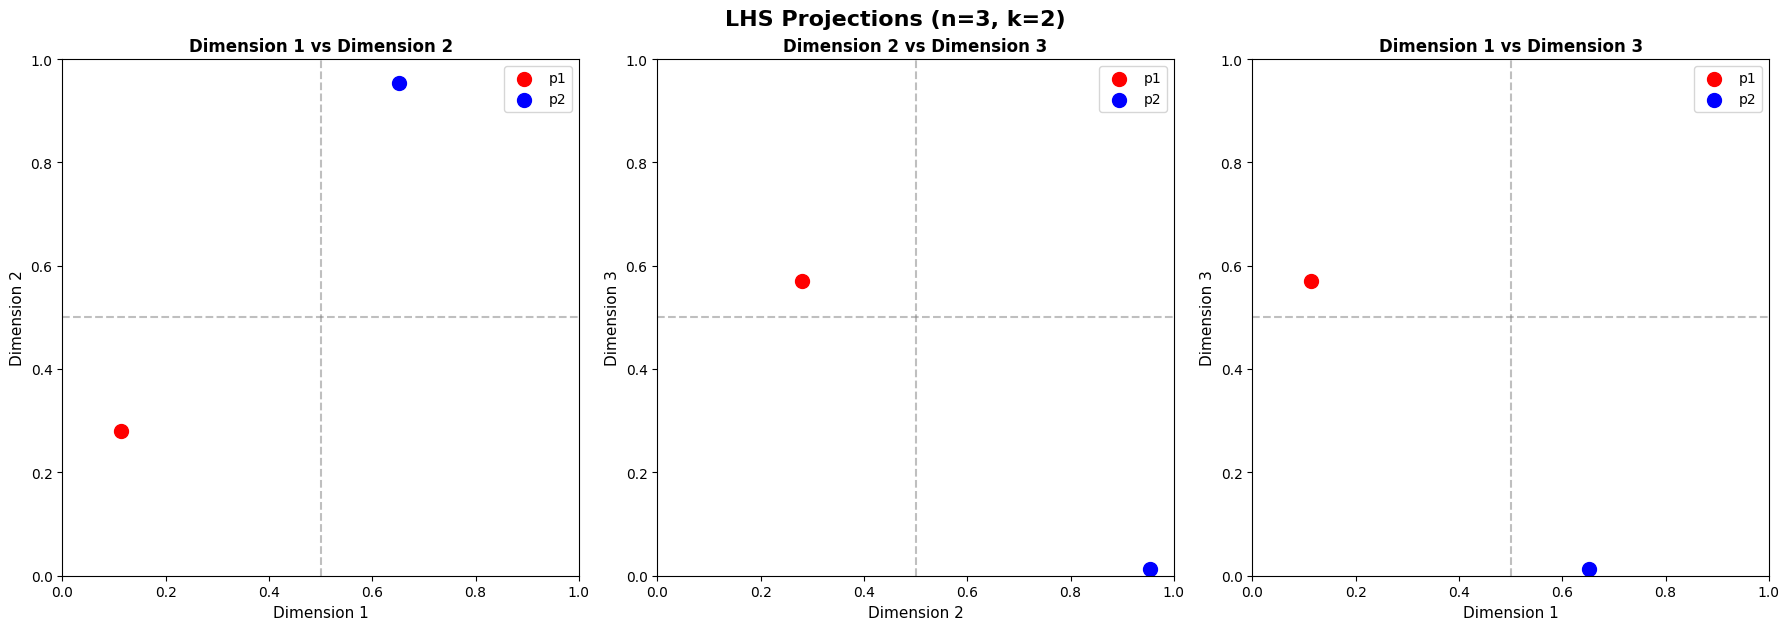

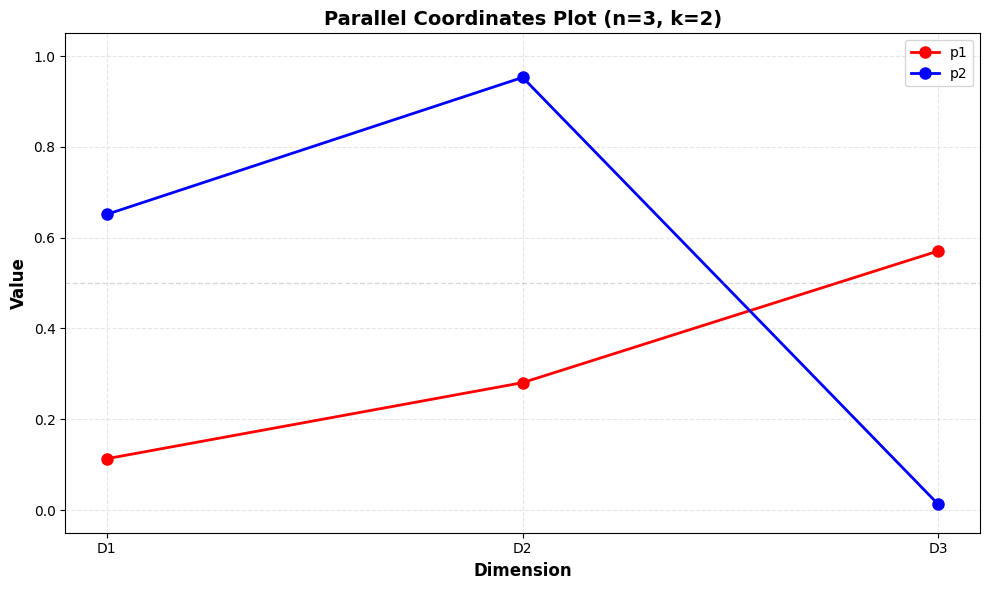

array([[0.11302198, 0.28056078, 0.57070104],
       [0.65131599, 0.95291133, 0.01218882]])

In [5]:
# Multiple views with lists
show_lhd(n=3, k=2, elev=[20, 30, 60], azim=[45, 60, 0])


## Example: 3D with 3 points

Sample points (n=3, k=3):
[[0.07534798 0.18704052 0.38046736]
 [0.43421066 0.96860755 0.00812588]
 [0.74628677 0.40464523 0.95729546]]



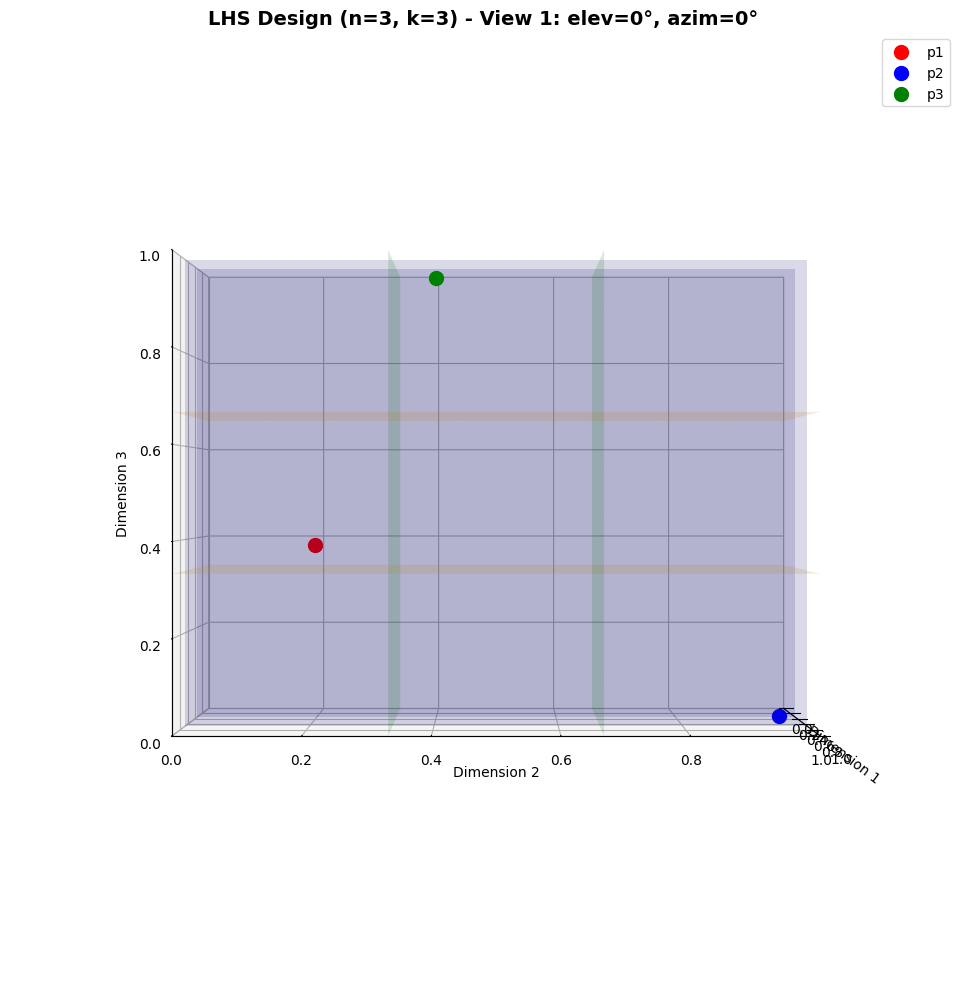

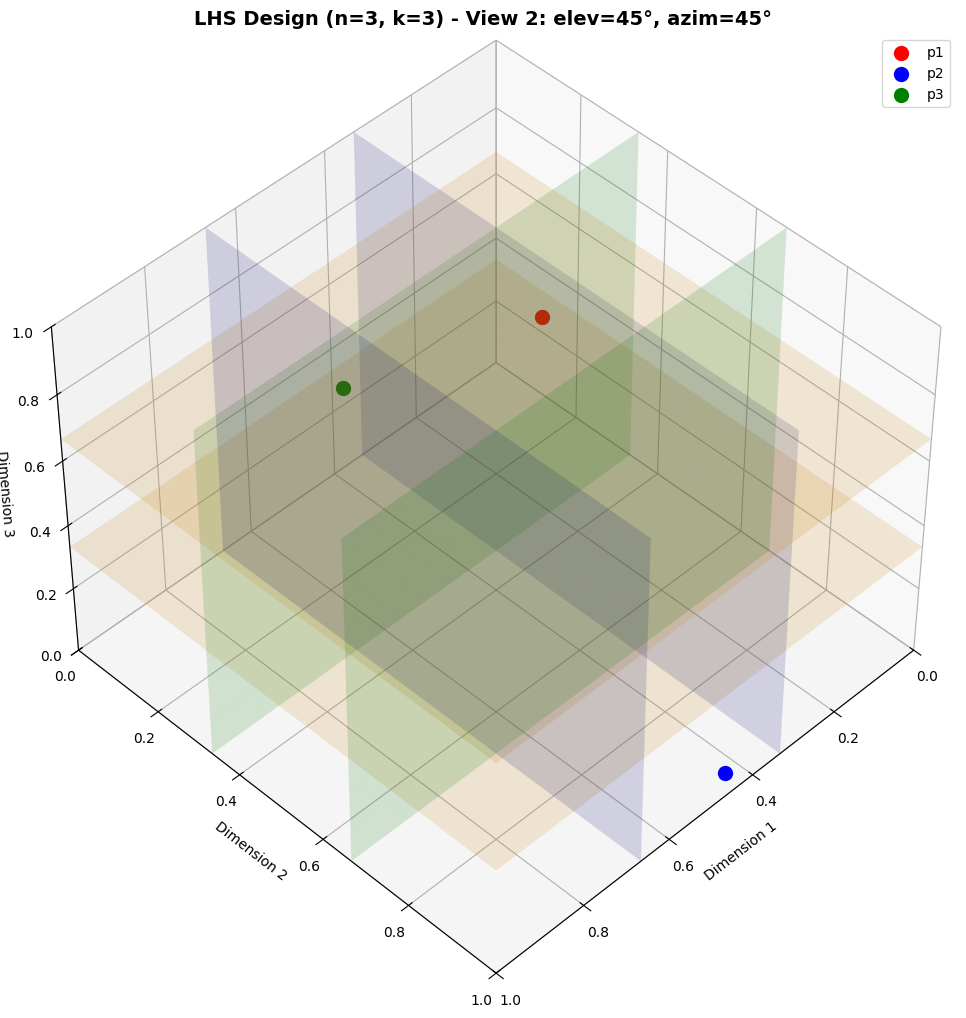

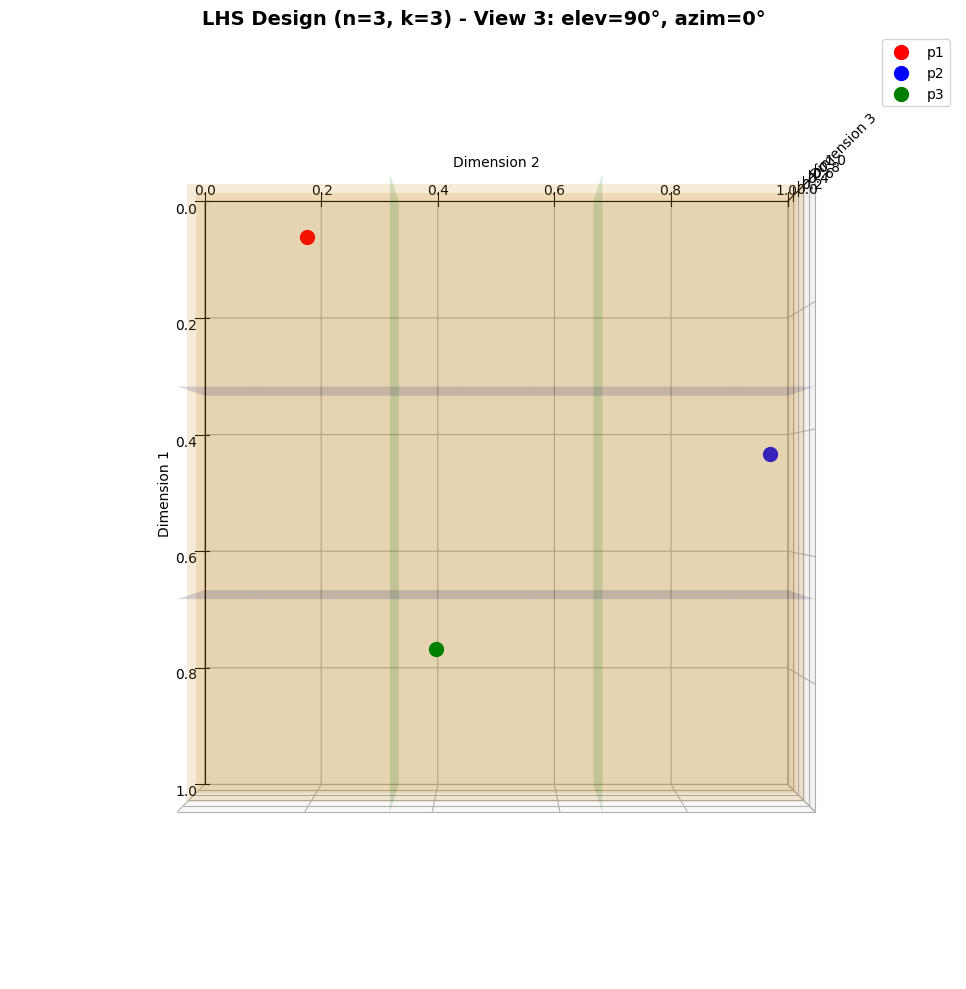

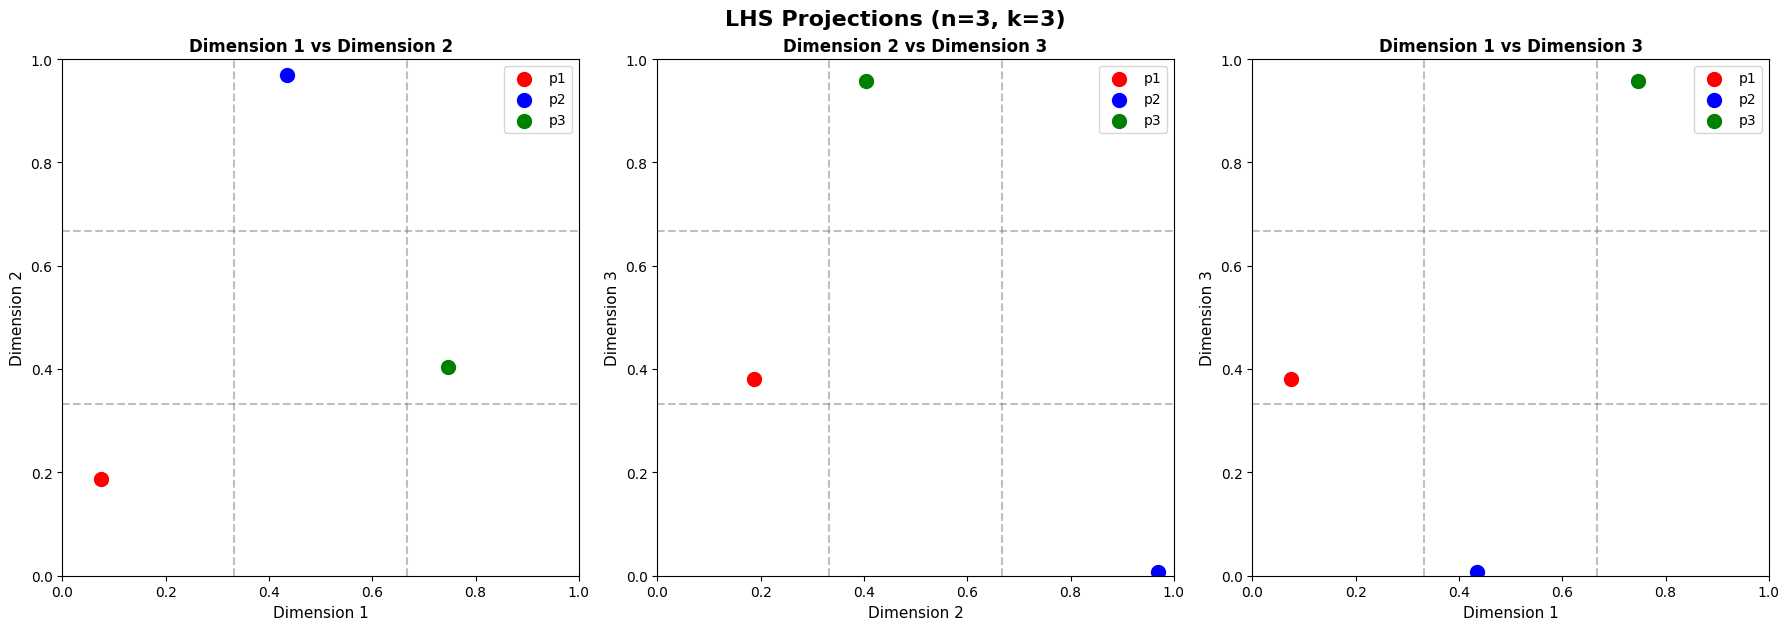

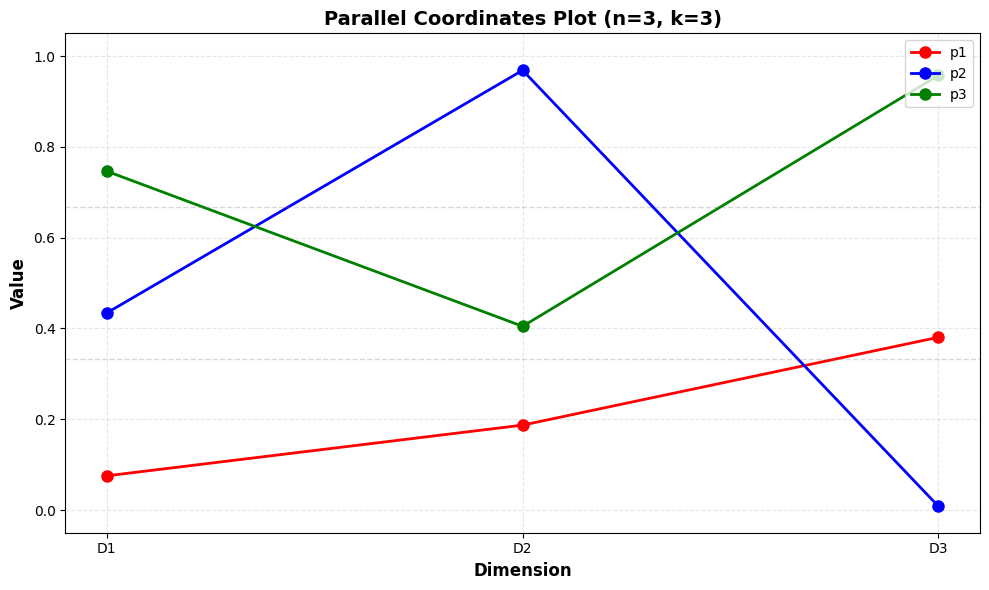

array([[0.07534798, 0.18704052, 0.38046736],
       [0.43421066, 0.96860755, 0.00812588],
       [0.74628677, 0.40464523, 0.95729546]])

In [6]:
show_lhd(n=3, k=3, elev=[0, 45, 90], azim=[0, 45, 0])

# Example: 3D with 3 points

Sample points (n=3, k=3):
[[0.07534798 0.18704052 0.38046736]
 [0.43421066 0.96860755 0.00812588]
 [0.74628677 0.40464523 0.95729546]]



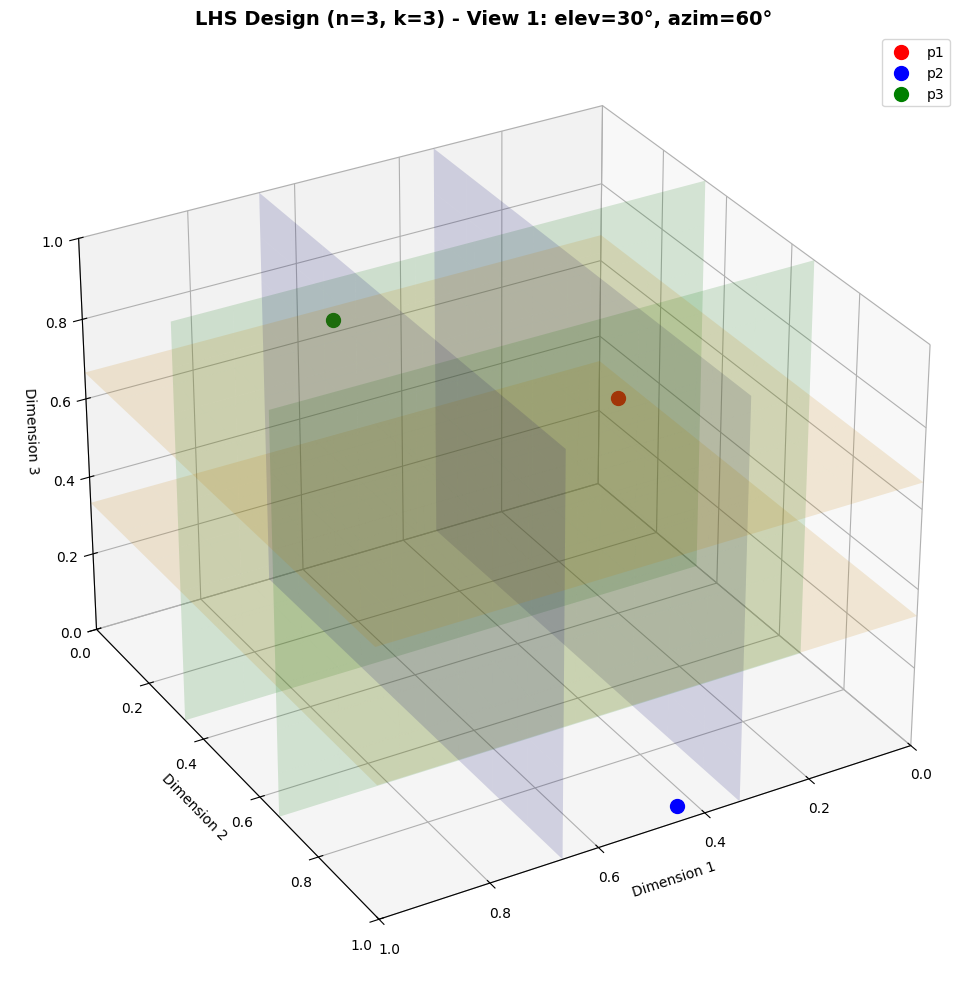

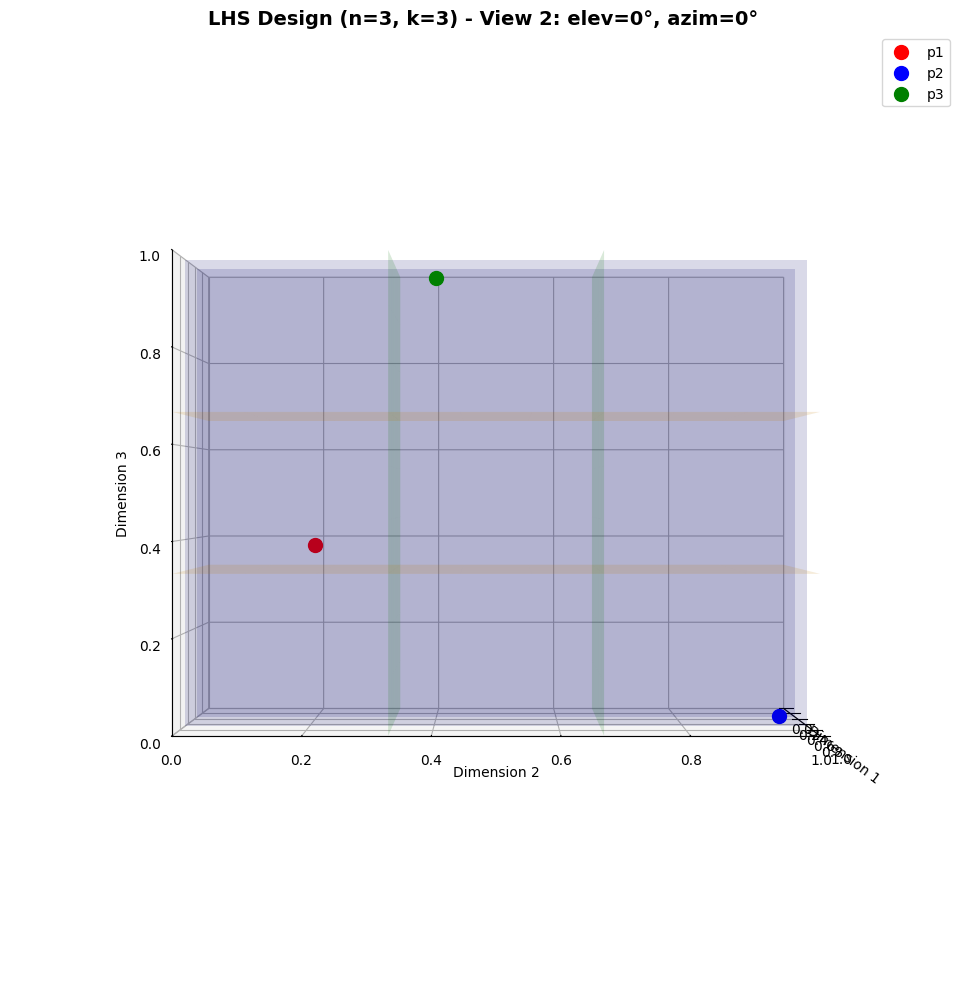

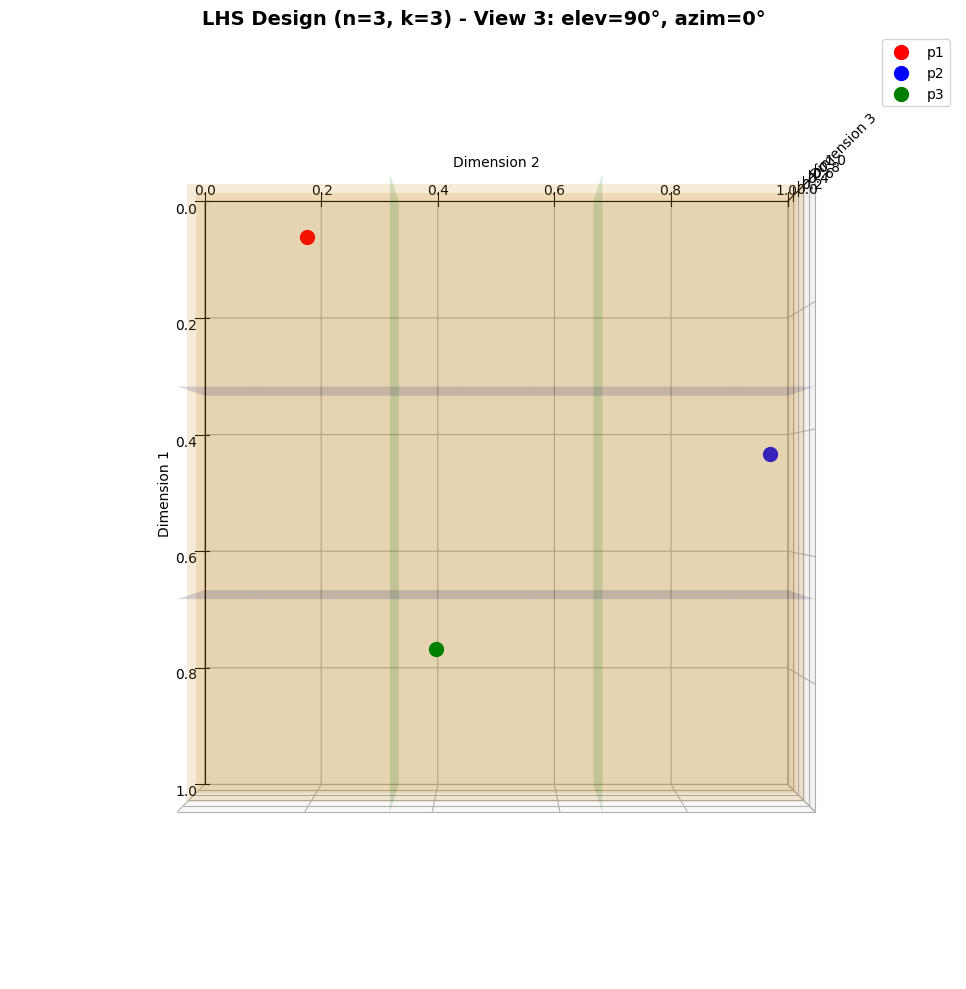

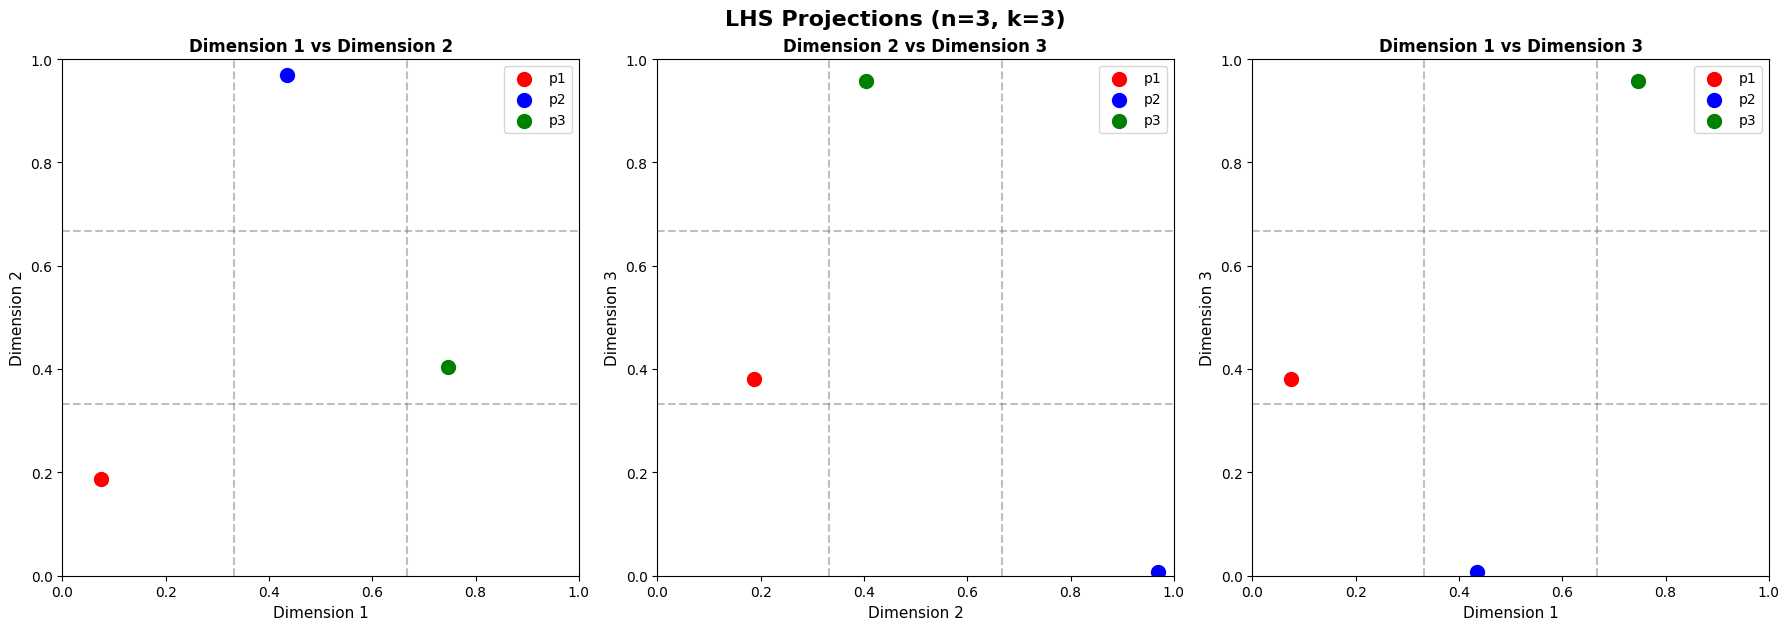

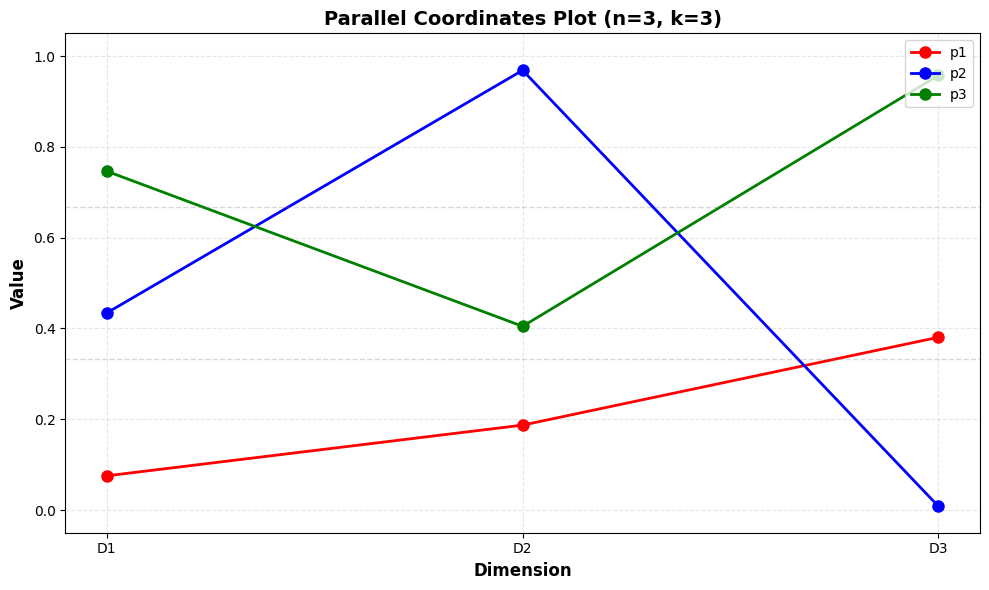

In [7]:
sample1 = show_lhd(n=3, k=3, elev=[30,0,90], azim=[60, 0,0])

## Example 1: 3D with 4 points

Sample points (n=3, k=4):
[[0.80651099 0.89028039 0.03535052]
 [0.07565799 0.22645566 0.25609441]
 [0.30971507 0.55348392 0.96797159]
 [0.63740352 0.40730049 0.51830875]]



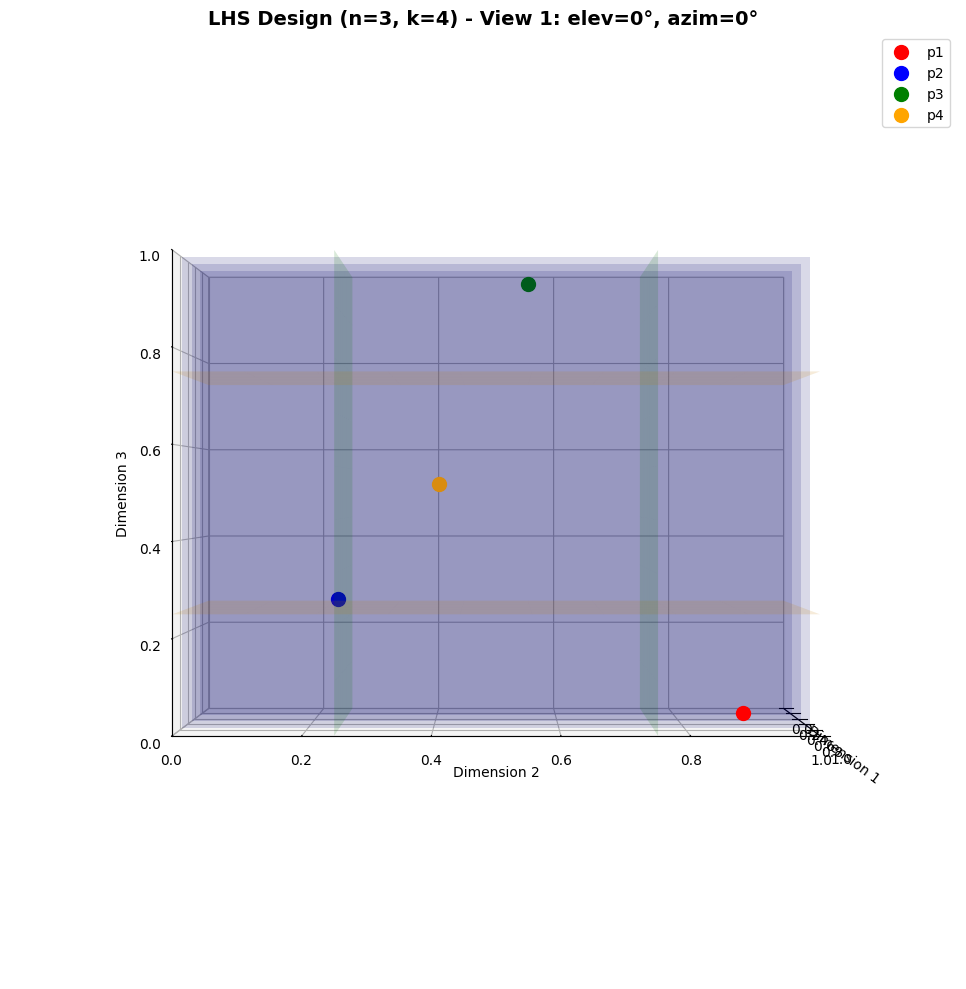

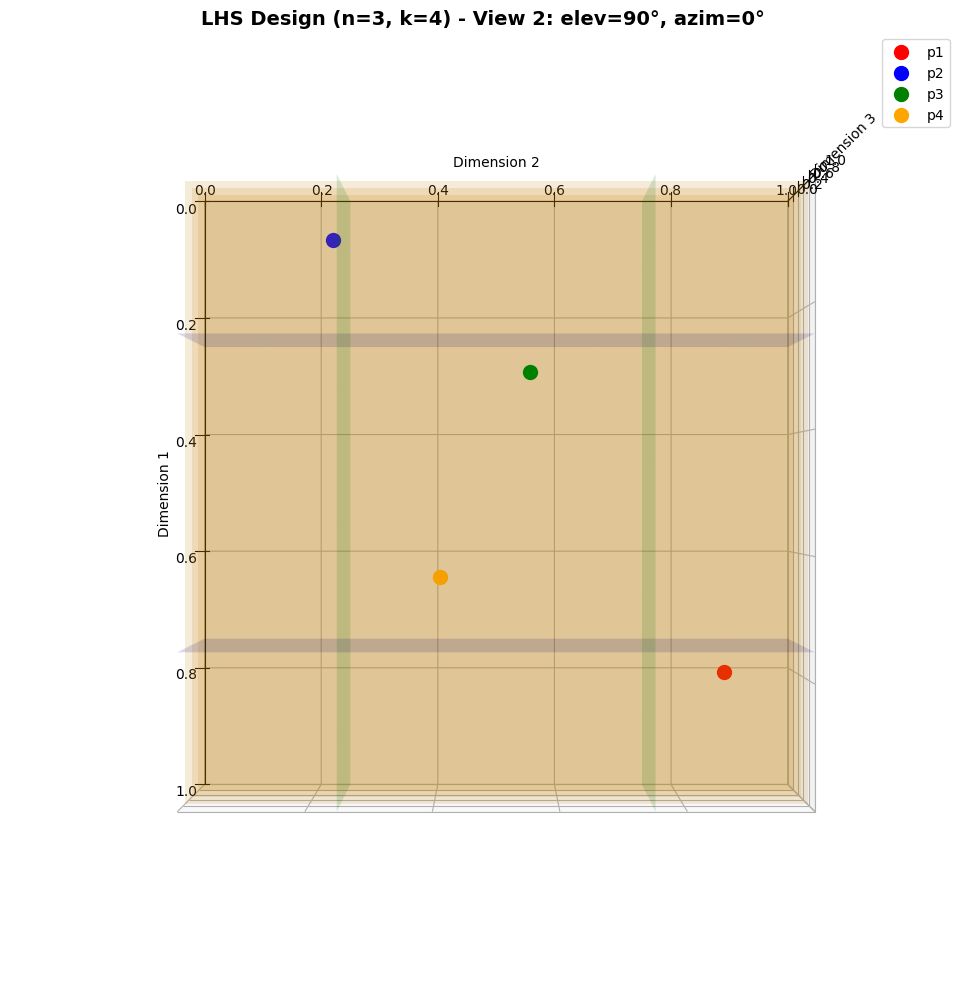

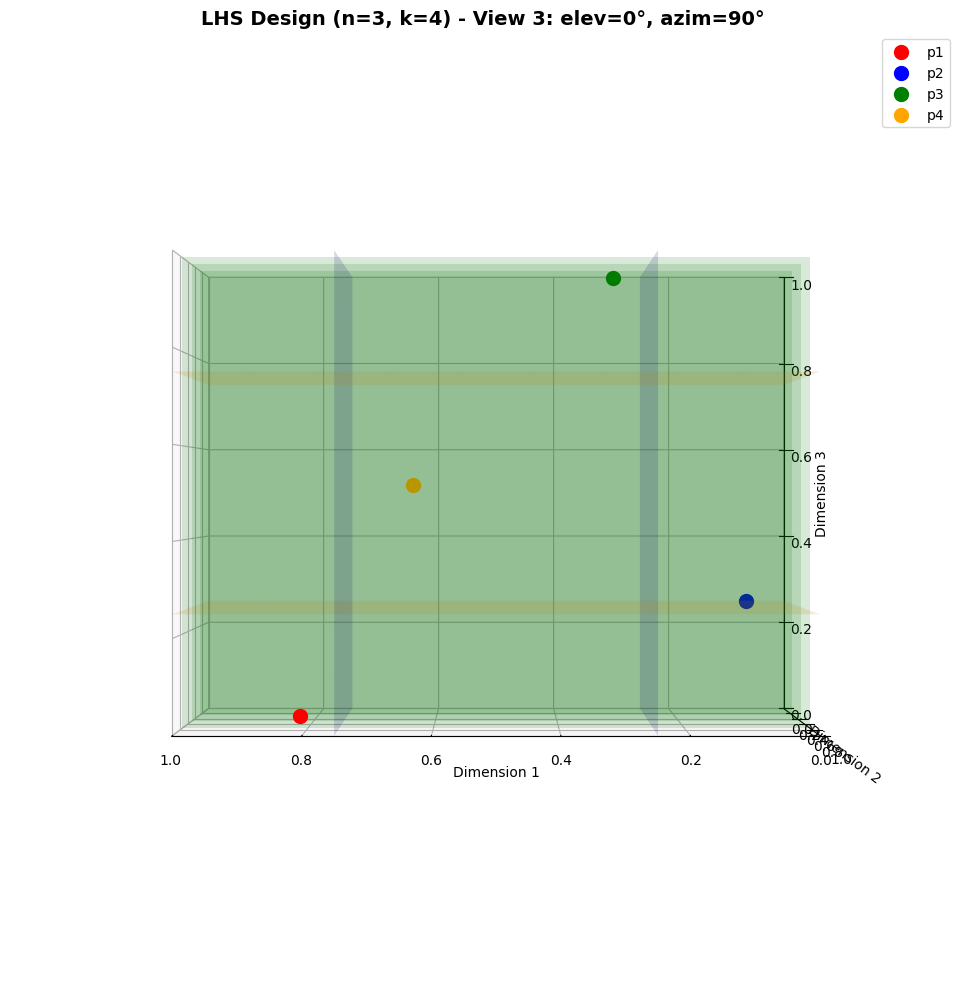

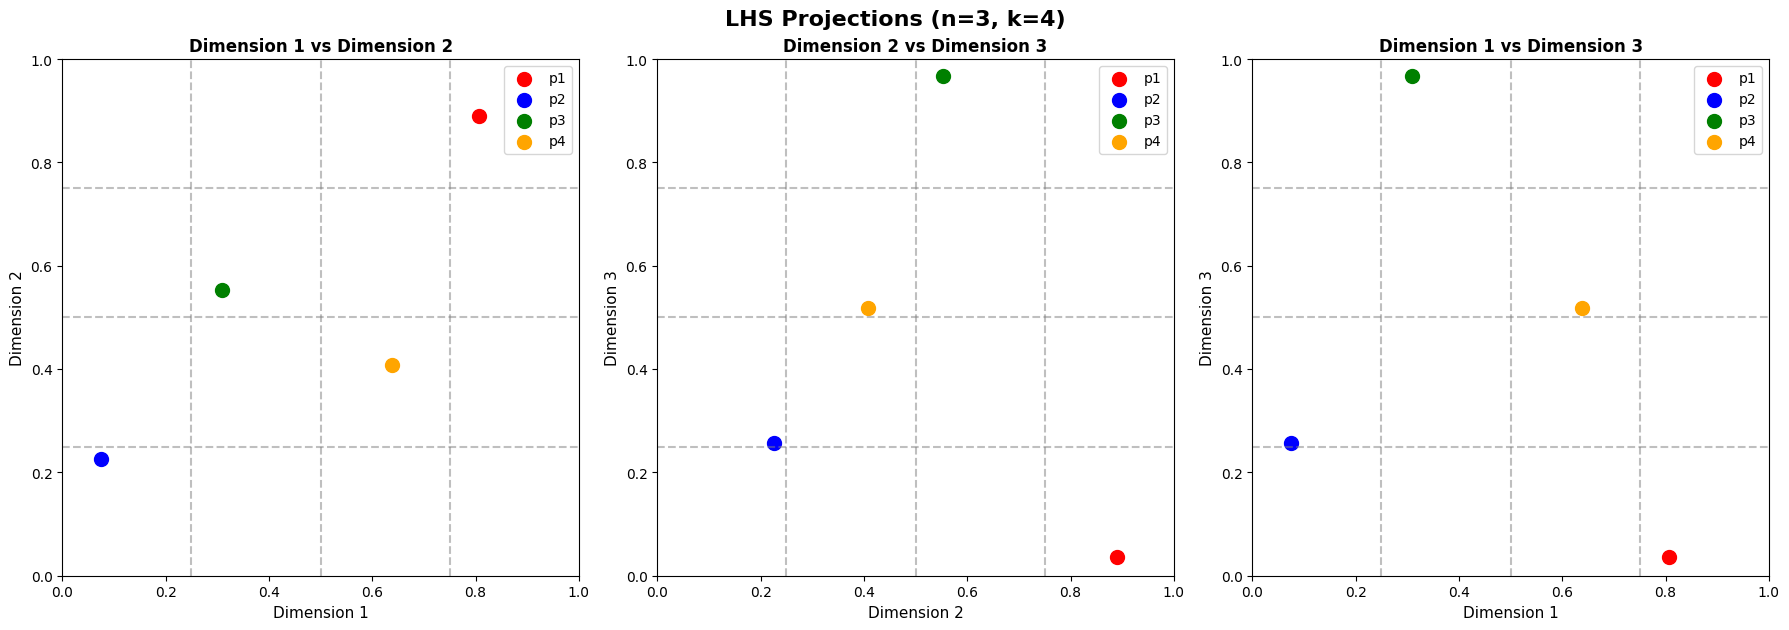

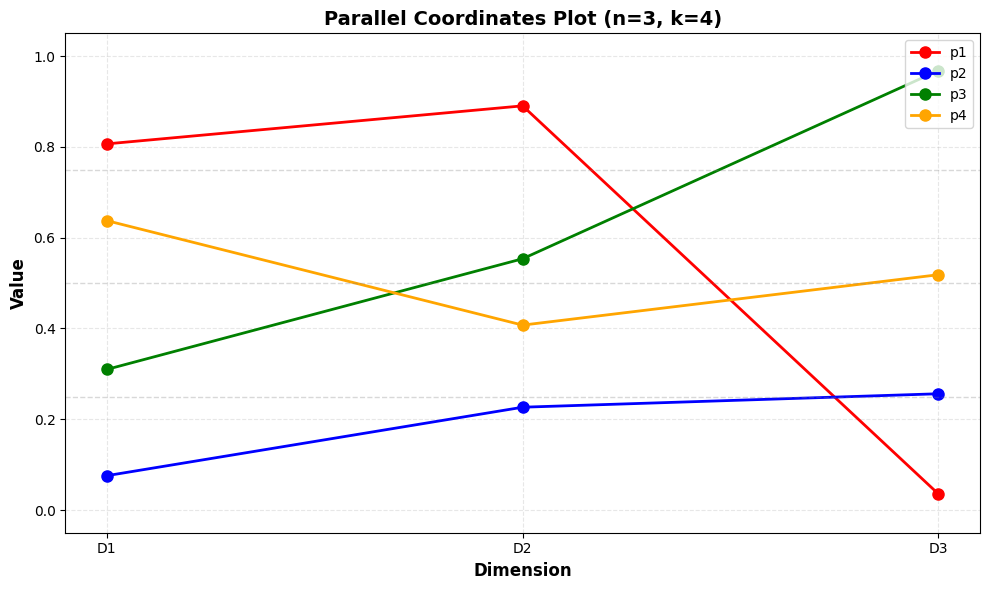

In [8]:

sample1 = show_lhd(n=3, k=4, elev=[0,90,0], azim=[0,0,90])

Sample points (n=5, k=3):
[[0.40868132 0.18704052 0.38046736 0.43421066 0.30194088]
 [0.00812588 0.41295343 0.0713119  0.95729546 0.84987135]
 [0.87640066 0.69107834 0.78537829 0.05907946 0.51886193]]



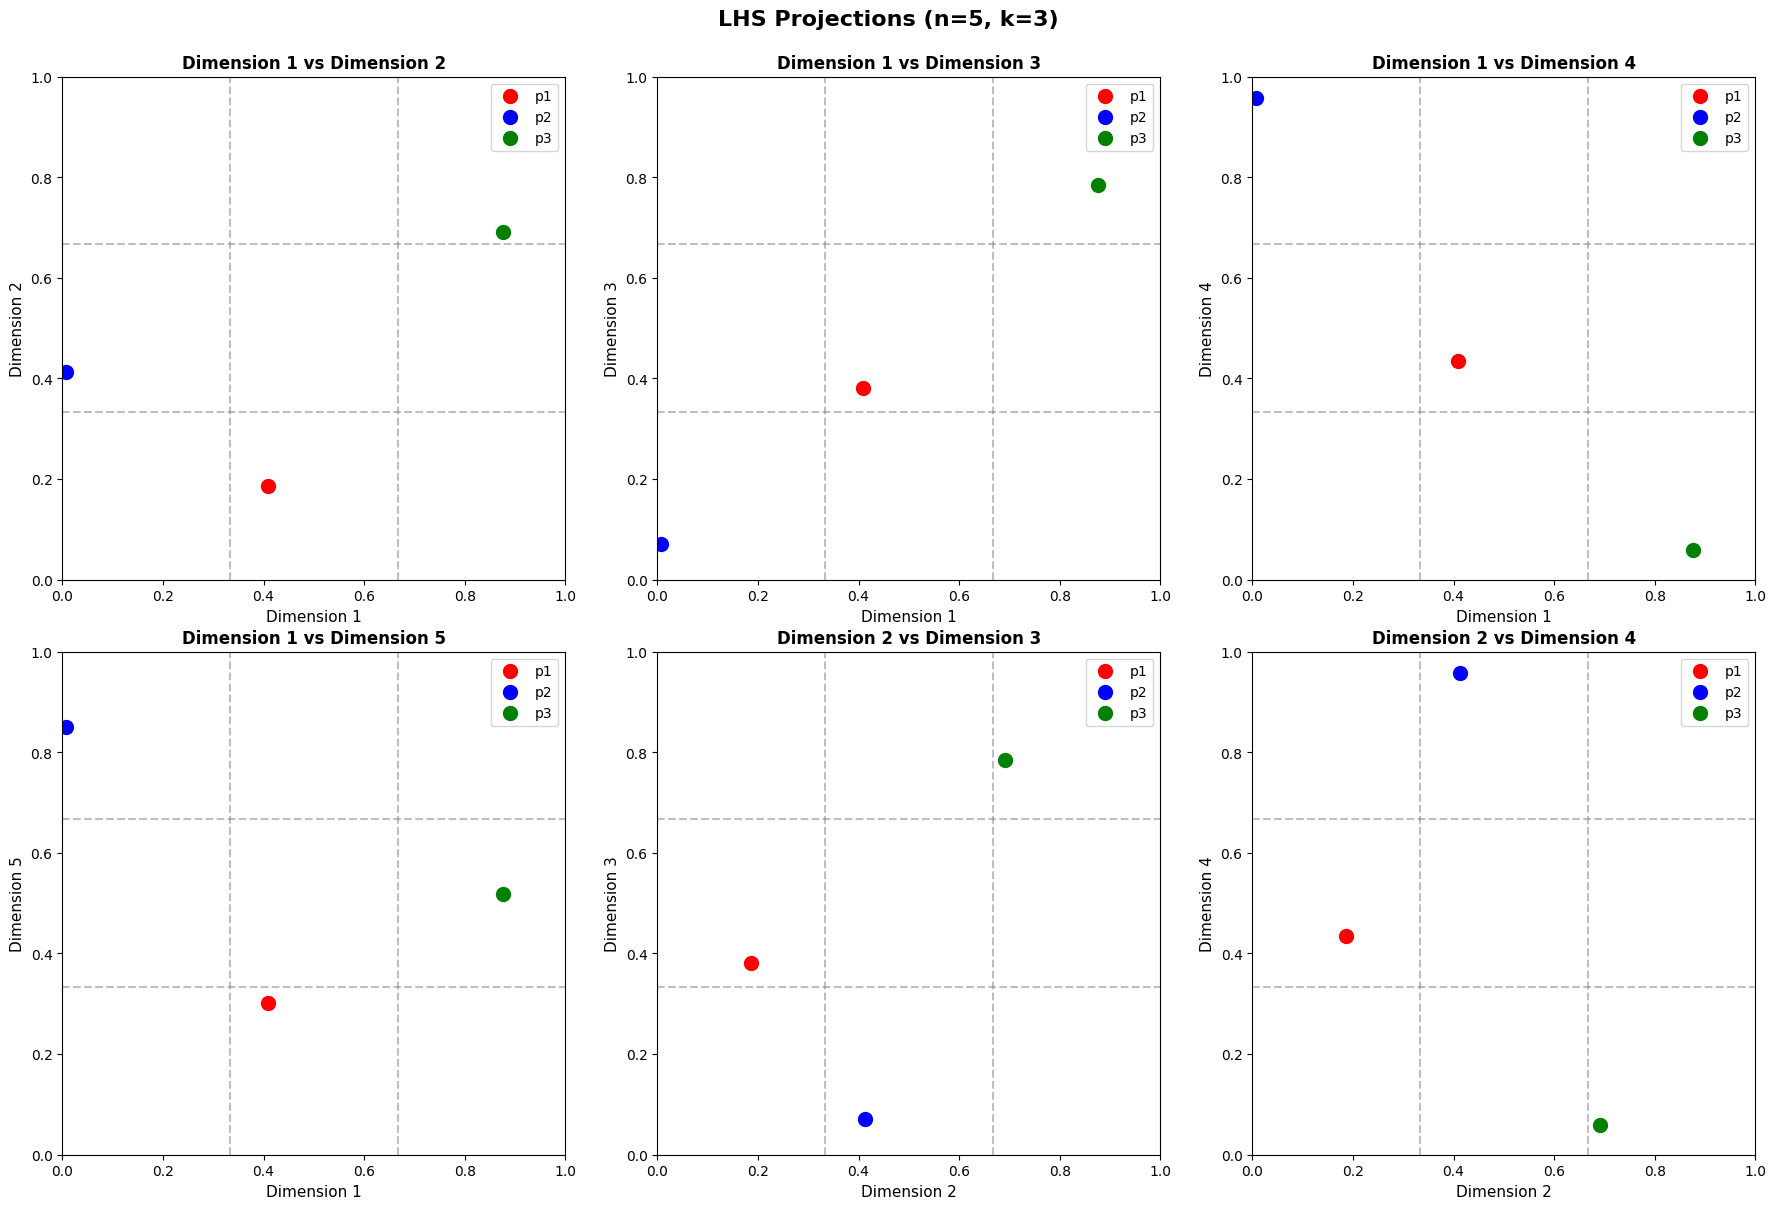

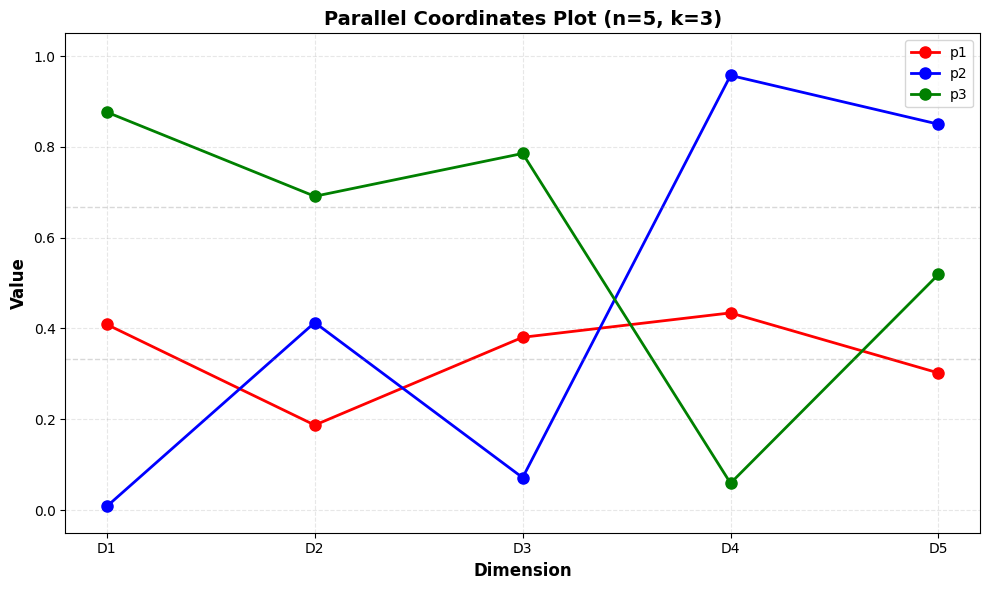

In [9]:
# Example 2: 5D with 3 points (shows 6 projections in a grid)
sample2 = show_lhd(n=5, k=3)

Sample points (n=2, k=5):
[[0.84520879 0.11222431]
 [0.02828042 0.66052639]
 [0.58116453 0.80487553]
 [0.64777206 0.44278714]
 [0.37437727 0.30992281]]



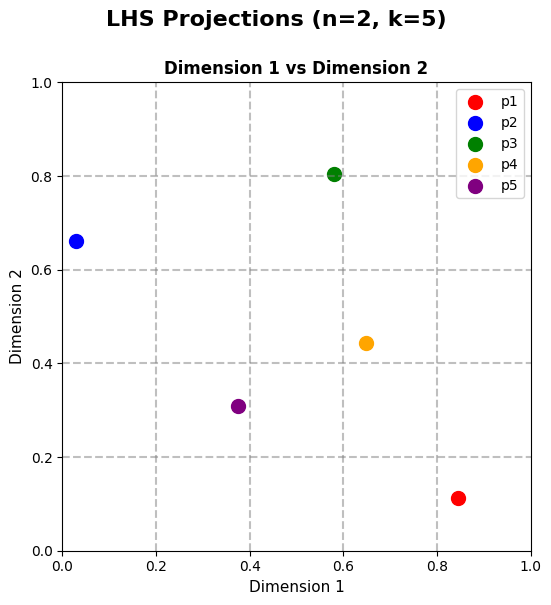

In [10]:
# Example 3: 2D with 5 points
sample3 = show_lhd(n=2, k=5)